In [15]:
import pandas as pd
import numpy as np
import locale
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sympy.physics.units import current

In [16]:
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')

'de_DE.UTF-8'

In [17]:
tiker = "ALK"
df = pd.read_csv(f"stocks/data/{tiker}.csv")
print(df.isna().sum())
df.ffill(axis=0, inplace=True)
print(df.isna().sum())

Date                  0
last_traded_price     0
max                  51
min                  51
avg_price             0
promet                0
volume                0
promet_BEST           0
promet_vo_denari      0
dtype: int64
Date                 0
last_traded_price    0
max                  0
min                  0
avg_price            0
promet               0
volume               0
promet_BEST          0
promet_vo_denari     0
dtype: int64


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               2679 non-null   object 
 1   last_traded_price  2679 non-null   object 
 2   max                2679 non-null   object 
 3   min                2679 non-null   object 
 4   avg_price          2679 non-null   object 
 5   promet             2679 non-null   object 
 6   volume             2679 non-null   float64
 7   promet_BEST        2679 non-null   object 
 8   promet_vo_denari   2679 non-null   object 
dtypes: float64(1), object(8)
memory usage: 188.5+ KB


In [20]:
def parse_numeric_to_float(dataframe: pd.DataFrame):
    for col in dataframe.columns:
        if col=='Date':
            dataframe[col] = pd.to_datetime(dataframe[col], format='%d.%m.%Y')
        elif dataframe[col].dtype == 'object': 
            try:
                dataframe[col] = dataframe[col].apply(locale.atof).astype('float64')
            except:
                pass
            
parse_numeric_to_float(df)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2679 entries, 0 to 2678
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2679 non-null   datetime64[ns]
 1   last_traded_price  2679 non-null   float64       
 2   max                2679 non-null   float64       
 3   min                2679 non-null   float64       
 4   avg_price          2679 non-null   float64       
 5   promet             2679 non-null   float64       
 6   volume             2679 non-null   float64       
 7   promet_BEST        2679 non-null   float64       
 8   promet_vo_denari   2679 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 188.5 KB


In [ ]:
print(df.iloc[-14:,])

In [22]:
#Data preparation

#Postavuvanje na target
target = 'avg_price'
#Atributi za shiftanje
attributes = df.columns[1:]
attributes = ['max','min','avg_price' ]
#inicijalizacija na lag
lag = 7
#broj na atributi (originalno)
n_features = len(attributes)
# n_features = 1 #ako vo trening koristime samo 1 atribut
#dodavanje na lag na atributite
def drop_columns(dataframe: pd.DataFrame, columns):
    to_delete = [col for col in dataframe.columns if col not in columns]
    return dataframe.drop(to_delete, axis=1)


def shift_attributes_by_x(dataframe: pd.DataFrame, attributes, x:int):
    copy = dataframe.copy()
    for i in range(x, 0, -1):
        for attr in attributes:
            lag = attr+'_lag_'+str(i)
            copy[lag] = copy[attr].shift(i)
    copy.dropna(inplace=True)
    return copy
    
#reshape na originalnoto treniracko mnozestvo za da moze da se koristi vo LSTM-modelot
def reshape(X:pd.DataFrame, time_step):
    # scaler = StandardScaler()
    # tmp = scaler.fit_transform(X)
    tmp = X.to_numpy()
    reshaped = tmp.reshape(tmp.shape[0], time_step, n_features)
    return reshaped

#agregiranje na podatocite na nivo na mesec
def group_by_month(dataframe: pd.DataFrame):    
    by_month = dataframe.copy()
    by_month['Date'] = pd.to_datetime(by_month['Date'], dayfirst=True)
    by_month = by_month.groupby(pd.Grouper(key='Date', freq='ME')).agg({
        'last_traded_price': 'last',       # Last closing value of the month
        'max': 'max',         # Maximum high of the month
        'min': 'min',          # Minimum low of the month
        'avg_price': 'mean',    #average per month
        'promet': 'mean',
        'volume': 'sum',    # Total BTC volume for the month
        'promet_BEST': 'sum',     # Total USD volume for the month
        'promet_vo_denari': 'sum'     # Total USD volume for the month
        
    })
    return by_month

reduced_dataset = drop_columns(df, attributes)
df_shifted_7d = shift_attributes_by_x(reduced_dataset, attributes, lag)
#prvo da se zeme target kolonata pred da ja trgneme od trening datasetot
test = df_shifted_7d[target]
#trganje na orginalnite koloni od datasetot
df_shifted_7d.drop(attributes, axis=1, inplace=True)
df_shifted_7d.tail(14)


,max_lag_7,min_lag_7,avg_price_lag_7,max_lag_6,min_lag_6,avg_price_lag_6,max_lag_5,min_lag_5,avg_price_lag_5,max_lag_4,...,avg_price_lag_4,max_lag_3,min_lag_3,avg_price_lag_3,max_lag_2,min_lag_2,avg_price_lag_2,max_lag_1,min_lag_1,avg_price_lag_1
2665,22350.0,22300.0,22301.63,22300.0,22100.0,22240.91,22295.0,22100.0,22140.92,22296.0,...,22246.02,22300.0,22249.0,22254.15,22300.0,22200.0,22274.43,22500.0,22200.0,22288.64
2666,22300.0,22100.0,22240.91,22295.0,22100.0,22140.92,22296.0,22160.0,22246.02,22300.0,...,22254.15,22300.0,22200.0,22274.43,22500.0,22200.0,22288.64,22251.0,22200.0,22243.51
2667,22295.0,22100.0,22140.92,22296.0,22160.0,22246.02,22300.0,22249.0,22254.15,22300.0,...,22274.43,22500.0,22200.0,22288.64,22251.0,22200.0,22243.51,22251.0,22200.0,22225.74
2668,22296.0,22160.0,22246.02,22300.0,22249.0,22254.15,22300.0,22200.0,22274.43,22500.0,...,22288.64,22251.0,22200.0,22243.51,22251.0,22200.0,22225.74,22350.0,22250.0,22266.81
2669,22300.0,22249.0,22254.15,22300.0,22200.0,22274.43,22500.0,22200.0,22288.64,22251.0,...,22243.51,22251.0,22200.0,22225.74,22350.0,22250.0,22266.81,22260.0,22200.0,22252.00
2670,22300.0,22200.0,22274.43,22500.0,22200.0,22288.64,22251.0,22200.0,22243.51,22251.0,...,22225.74,22350.0,22250.0,22266.81,22260.0,22200.0,22252.00,22250.0,22250.0,22250.00
2671,22500.0,22200.0,22288.64,22251.0,22200.0,22243.51,22251.0,22200.0,22225.74,22350.0,...,22266.81,22260.0,22200.0,22252.00,22250.0,22250.0,22250.00,22310.0,22250.0,22291.33
2672,22251.0,22200.0,22243.51,22251.0,22200.0,22225.74,22350.0,22250.0,22266.81,22260.0,...,22252.00,22250.0,22250.0,22250.00,22310.0,22250.0,22291.33,22351.0,22300.0,22316.35
2673,22251.0,22200.0,22225.74,22350.0,22250.0,22266.81,22260.0,22200.0,22252.00,22250.0,...,22250.00,22310.0,22250.0,22291.33,22351.0,22300.0,22316.35,22300.0,22250.0,22293.98
2674,22350.0,22250.0,22266.81,22260.0,22200.0,22252.00,22250.0,22250.0,22250.00,22310.0,...,22291.33,22351.0,22300.0,22316.35,22300.0,22250.0,22293.98,22300.0,22298.0,22299.74


In [23]:
test.tail()

2674    22484.06
2675    22997.62
2676    23193.84
2677    23432.42
2678    23793.41
Name: avg_price, dtype: float64

In [24]:
train = df_shifted_7d

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train, test, test_size=0.3, shuffle=False)
#Reshape na X
x_train = reshape(x_train, lag)
x_test = reshape(x_test, lag)

In [25]:
print("X Training shape: "+str(x_train.shape))
print("X Testing shape: "+str(x_test.shape))
print("y Training shape: "+str(y_train.shape))
print("y Testing shape: "+str(y_test.shape))

X Training shape: (1870, 7, 3)
X Testing shape: (802, 7, 3)
y Training shape: (1870,)
y Testing shape: (802,)


In [26]:
x_train

array([[[ 5100.  ,  5070.  ,  5087.79],
        [ 4430.  ,  4421.  ,  4425.75],
        [ 4500.  ,  4422.  ,  4479.75],
        ...,
        [ 4500.  ,  4400.  ,  4471.61],
        [ 4500.  ,  4455.  ,  4474.22],
        [ 4450.  ,  4400.  ,  4424.88]],

       [[ 4430.  ,  4421.  ,  4425.75],
        [ 4500.  ,  4422.  ,  4479.75],
        [ 4500.  ,  4410.  ,  4488.9 ],
        ...,
        [ 4500.  ,  4455.  ,  4474.22],
        [ 4450.  ,  4400.  ,  4424.88],
        [ 4430.  ,  4428.  ,  4429.54]],

       [[ 4500.  ,  4422.  ,  4479.75],
        [ 4500.  ,  4410.  ,  4488.9 ],
        [ 4500.  ,  4400.  ,  4471.61],
        ...,
        [ 4450.  ,  4400.  ,  4424.88],
        [ 4430.  ,  4428.  ,  4429.54],
        [ 4430.  ,  4430.  ,  4430.  ]],

       ...,

       [[15878.  , 15761.  , 15777.06],
        [15800.  , 15799.  , 15799.93],
        [15900.  , 15800.  , 15810.  ],
        ...,
        [15850.  , 15800.  , 15823.48],
        [16000.  , 15900.  , 15983.12],
        [

In [27]:
x_test[-5:]

array([[[22350.  , 22250.  , 22266.81],
        [22260.  , 22200.  , 22252.  ],
        [22250.  , 22250.  , 22250.  ],
        [22310.  , 22250.  , 22291.33],
        [22351.  , 22300.  , 22316.35],
        [22300.  , 22250.  , 22293.98],
        [22300.  , 22298.  , 22299.74]],

       [[22260.  , 22200.  , 22252.  ],
        [22250.  , 22250.  , 22250.  ],
        [22310.  , 22250.  , 22291.33],
        [22351.  , 22300.  , 22316.35],
        [22300.  , 22250.  , 22293.98],
        [22300.  , 22298.  , 22299.74],
        [22502.  , 22301.  , 22484.06]],

       [[22250.  , 22250.  , 22250.  ],
        [22310.  , 22250.  , 22291.33],
        [22351.  , 22300.  , 22316.35],
        [22300.  , 22250.  , 22293.98],
        [22300.  , 22298.  , 22299.74],
        [22502.  , 22301.  , 22484.06],
        [23000.  , 22990.  , 22997.62]],

       [[22310.  , 22250.  , 22291.33],
        [22351.  , 22300.  , 22316.35],
        [22300.  , 22250.  , 22293.98],
        [22300.  , 22298.  , 22299

In [28]:
#Pravenje na model
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

#instanciranje na modelot
model = Sequential([
    Input((lag, n_features)),
    LSTM(56, activation='relu'),
    Dense(1)
])

model.compile(loss="mse", optimizer="adam")

history = model.fit(x_train, y_train, validation_split=0.1, epochs=70, batch_size=8)


Epoch 1/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4753451.0000 - val_loss: 251660.2188
Epoch 2/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 80312.9219 - val_loss: 215614.9375
Epoch 3/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 68696.7109 - val_loss: 216625.4375
Epoch 4/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 48314.0977 - val_loss: 224308.8906
Epoch 5/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 66441.0781 - val_loss: 255301.4062
Epoch 6/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 67816.4922 - val_loss: 206775.7031
Epoch 7/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 55758.2461 - val_loss: 210387.6094
Epoch 8/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 57374.9492 - val_loss: 215597.0312
Epoch 9/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54226.6562 - val_loss: 208199.0156
Epoch 10/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 84426.9453 - val_loss: 267322.9375
Epoch 11/70
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms

In [29]:
pred = model.predict(x_test)
print(pred[4])

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[16206.8125]


In [30]:
r2_score(y_test, pred)

0.969309621483447

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


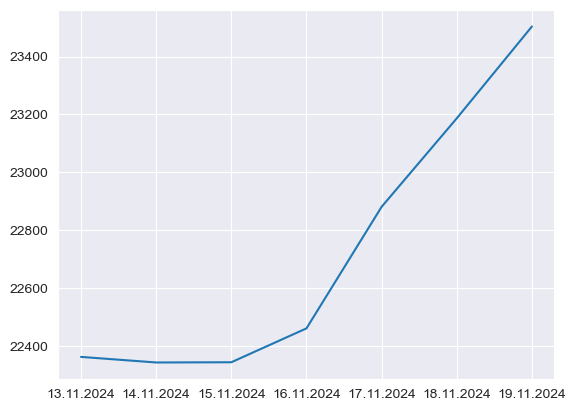

In [31]:
from datetime import timedelta

n=7
current_date = df['Date'][len(df)-1]
next_n_days = [(current_date + timedelta(days=i)).strftime("%d.%m.%Y") for i in range(1, n+1)]
#
# for day in next_n_days:

next_predicted_n_days = model.predict(x_test[n*(-1):])
plt.plot(next_n_days, next_predicted_n_days)

<Axes: xlabel='Date', ylabel='avg_price'>

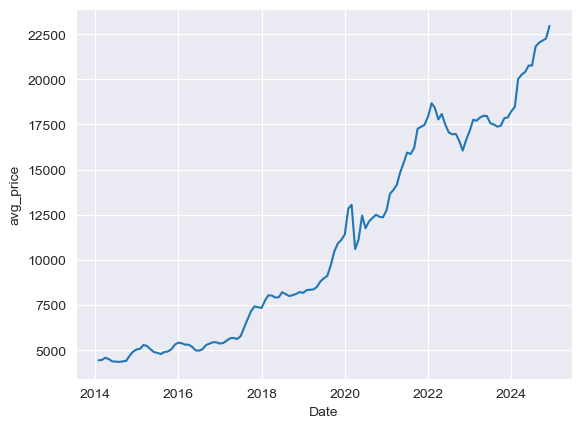

In [32]:
byMonth = group_by_month(df)
sns.lineplot(data=byMonth, x='Date', y='avg_price')